# Youtube Dataset Analysis

### Data Decription 

Our raw dataset contains information about 200 trending videos on YouTube across 205 days. This data was collected from Canada, United States, Great Britain, Germany, France, Russia, Mexico, South Korea, Japan, and India. It includes the video id, the date(s) the video was trending, the video title, the channel name, the number of likes, dislikes, and views at that trending date, the category ID corresponding to the relevant genre of the video, the comment count, the time the video was published, all its tags it was posted under, a link to the thumbnail image used for the video, a boolean values for whether or not the video ever had its comments disabled, ratings disabled, or had an error/was removed, a direct copy and paste of each video’s description, and the link ID to the video. Youtube determines if a video is trending by looking at various factors including number of views, shares, comments, and likes. This dataset was created to explore which videos are trending in certain countries and why, in regards to its raw data, perhaps to better understand how exactly a posted video goes viral and stays viral, and why it garners such attention. “Mitchell J”, a kaggle user, funded the creation of this dataset, and says in the description it was collected using YouTube’s own API’s to gather the relevant raw data. In that regard, since YouTube’s own API was used to scrape this data, only readily-available surface data on the video is included here. Essentially any statistic on a video that you can see when you watch a video is what is included here. 

In terms of pre-processing the data, we had to combine the files for all of the countries we decided to use into one data file. We decided to use only countries that had mostly characters that could be interpreted on the computer. These countries included Canada, Germany, France, Great Britain, and the United States. We decided to just look at the videos under the music category because Youtube is largely used for music. After loading all of the csv files and json files for each country, we determined the category number for music by looking at the json. We then filtered out any videos in each of the Canada, Germany, France, Great Britain, and the United States datasets that were not of the “Music” category. There were many repeats of trending videos on certain days across countries, so we added a column to the dataset that contained a list of countries that a particular video was trending in on a particular day. This allowed for us to just be able to append all of the datasets together and drop the duplicates to give us unique rows, but still distinguish which videos were trending when and in what countries. Additionally we dropped the columns with the link for the thumbnail image of the video, the category id, since they were all the same, and for the description of the video because we felt we would not use it in our analysis.

After this initial filtering, we still noticed some issues. Many videos had titles that were written in languages that did not port well into alpha-numeric characters, and showed up as glitchy unicode when looking at the raw data. In order to cut down on this, we filtered down each video that was essentially unusable due to its title/tags data. Each corresponding video per tag that did not contain only alphanumeric characters was flagged and removed from the csv. We also noticed many issues with the dating format of the videos. Each video had a corresponding column for the day it was trending, and the date it was published. The trending_day column was formatted oddly, in year/day/month, and the publish_date was a combined date/time string, so we formatted them all to be consistent. The publish_date was split into 2 columns, one representing the day, and one representing the exact time the video was uploaded. The trending_date column was formatted to the more standard month/day/year format, as was the published_day column. The publish_time column was left in 24 hour format to eliminate any issues with AM/PM. 

We combined multiple individual csv files, that were over 50 MB each, and json files into one csv file that is about 4 MB. After processing the raw data to combine multiple files into one cohesive dataset, our final dataset that we will use for this project contains trending videos, under the music category, over 205 days in Canada, Germany, France, Great Britain, and the United States. The attributes it contains are the video ids, the date the video was trending, the title of the video, the title of the channel of the video, the time the video was published, the date the video was published, the tags, the number of view, number of likes, number of dislikes, number of comments, and a list of the countries that a video was trending in on a particular day. 

**The code we used to create our dataset can be found in the file "Processing 2950 Data."**


Link to raw data: https://drive.google.com/drive/folders/1MEz1kqZ3AQVY_bdPxITEpsYqLlYEUBU-?usp=sharing

### Potential Problems
* Because we filtered out rows that contained unknown characters, we may find some gaps in our data. 
* An overall trend we pull may be incomplete as some foreign videos are missing
* For videos that are trending for more than one day, it may be difficult to reference them because their video id will be the same for both days. 
* We removed the “video description” column for all videos, which may impact our analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
## Import Dataset
df = pd.read_csv("youtube_music.csv")
df.head()

,video_id,trending_date,title,channel_title,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,countries_trending_in,publish-day,publish-time
0,5E4ZBSInqUU,11-14-2017,Marshmello - Blocks (Official Music Video),marshmello,"['marshmello', 'blocks', 'marshmello blocks', ...",687582,114188,1333,8371,False,False,False,['US'],2017-11-13,17:00:00
1,n1WpP7iowLc,11-14-2017,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,"['Eminem', 'Walk', 'On', 'Water', 'Aftermath/S...",17158531,787419,43420,125882,False,False,False,"['US', 'CA', 'GB', 'FR', 'DE']",2017-11-10,17:00:03
2,e_7zHm7GsYc,11-14-2017,Hunter Hayes - You Should Be Loved (Part One O...,Hunter Hayes,"['Hunter', 'Hayes', 'you should be loved', 'th...",13917,1318,24,76,False,False,False,['US'],2017-11-13,15:01:18
3,zZ9FciUx6gs,11-14-2017,Nickelback - The Betrayal Act III [Official Vi...,Nickelback,"['Nickelback', 'Feed The Machine', 'The Betray...",57169,6927,161,565,False,False,False,['US'],2017-11-13,15:31:44
4,PaJCFHXcWmM,11-14-2017,U2 - The Blackout,U2VEVO,"['U2', 'The', 'Blackout', 'Island', 'Records',...",60506,5389,106,455,False,False,False,['US'],2017-11-13,17:00:04


Below, we separate the numerical data (views, likes, dislikes, comment count) for each country in the dataset and put it into a dictionary, so it is easily accessible. 

In [4]:
total_number_videos = len(df)
stats = {"US":{"views":[], "likes":[], "dislikes":[], "comment_count":[]}, 
         "CA":{"views":[], "likes":[], "dislikes":[], "comment_count":[]}, 
         "GB":{"views":[], "likes":[], "dislikes":[], "comment_count":[]}, 
         "FR":{"views":[], "likes":[], "dislikes":[], "comment_count":[]}, 
         "DE":{"views":[], "likes":[], "dislikes":[], "comment_count":[]}}
for i in range(0, len(df)):
    row = df.loc[i]
    countries = row["countries_trending_in"]
    if 'US' in countries:
        stats["US"]["views"].append(row["views"])
        stats["US"]["likes"].append(row["likes"])
        stats["US"]["dislikes"].append(row["dislikes"])
        stats["US"]["comment_count"].append(row["comment_count"])
    if 'CA' in countries:
        stats["CA"]["views"].append(row["views"])
        stats["CA"]["likes"].append(row["likes"])
        stats["CA"]["dislikes"].append(row["dislikes"])
        stats["CA"]["comment_count"].append(row["comment_count"])
    if 'GB' in countries:
        stats["GB"]["views"].append(row["views"])
        stats["GB"]["likes"].append(row["likes"])
        stats["GB"]["dislikes"].append(row["dislikes"])
        stats["GB"]["comment_count"].append(row["comment_count"])
    if 'FR' in countries:
        stats["FR"]["views"].append(row["views"])
        stats["FR"]["likes"].append(row["likes"])
        stats["FR"]["dislikes"].append(row["dislikes"])
        stats["FR"]["comment_count"].append(row["comment_count"])
    if 'DE' in countries:
        stats["DE"]["views"].append(row["views"])
        stats["DE"]["likes"].append(row["likes"])
        stats["DE"]["dislikes"].append(row["dislikes"])
        stats["DE"]["comment_count"].append(row["comment_count"])

We then calculate the number of videos and the mean and standard deviation of the number of views, likes, dislikes, and comments for each country, as well as all of the countries combined. 

In [4]:
countries = list(stats.keys())
categories = list(stats["US"].keys())

means = {"views":[],"likes":[],"dislikes":[],"comment_count":[]}

for country in countries: 
    print(country)
    print("Number of Videos Trending:", len(stats[country]["likes"]), "\n")
    for category in categories:
        print("Mean "+category+":", int(np.mean(stats[country][category])))
        means[category].append(int(np.mean(stats[country][category])))
        print("Standard Deviation "+category+":", int(np.std(stats[country][category])))
        print()
    print("\n")

print("All Countries")
print("Total Number of Videos Trending:", len(df), "\n")
print("Mean views:", int(np.mean(df["views"])))
means["views"].append(int(np.mean(df["views"])))
print("Standard Deviation views:", int(np.std(df["views"])), "\n")

print("Mean likes:", int(np.mean(df["likes"])))
means["likes"].append(int(np.mean(df["likes"])))
print("Standard Deviation likes:", int(np.std(df["likes"])), "\n")

print("Mean dislikes:", int(np.mean(df["dislikes"])))
means["dislikes"].append(int(np.mean(df["dislikes"])))
print("Standard Deviation dislikes:", int(np.std(df["dislikes"])), "\n")

print("Mean comment_count:", int(np.mean(df["comment_count"])))
means["comment_count"].append(int(np.mean(df["comment_count"])))
print("Standard Deviation comment_count:", int(np.std(df["comment_count"])), "\n")

US
Number of Videos Trending: 3905 

Mean views: 6973529
Standard Deviation views: 17816536

Mean likes: 248155
Standard Deviation likes: 499074

Mean dislikes: 9116
Standard Deviation dislikes: 26522

Mean comment_count: 18614
Standard Deviation comment_count: 45416



CA
Number of Videos Trending: 2918 

Mean views: 4617326
Standard Deviation views: 7937471

Mean likes: 211814
Standard Deviation likes: 348443

Mean dislikes: 7758
Standard Deviation dislikes: 15513

Mean comment_count: 17607
Standard Deviation comment_count: 31266



GB
Number of Videos Trending: 7112 

Mean views: 12995548
Standard Deviation views: 31215703

Mean likes: 296022
Standard Deviation likes: 552548

Mean dislikes: 13734
Standard Deviation dislikes: 38158

Mean comment_count: 21285
Standard Deviation comment_count: 47685



FR
Number of Videos Trending: 1827 

Mean views: 3201673
Standard Deviation views: 6403962

Mean likes: 181244
Standard Deviation likes: 329272

Mean dislikes: 6175
Standard Deviation di

On average, trending videos in Great Britain get more views than in other countries. The mean number of views is greater than that of any country and total. However, the standard deviation is also highest, which could point to the data for Great Britain containing just a few very highly viewed videos. It may be that not all trending videos have a higher number of views in Great Britain than all of the other countries we look at, but just a few do and those outliers are what make the mean nnumber of views much higher. 

The average number of likes for a trending video is pretty consistent across countries. The mean number of likes are all approximately the 200,000 for each country and total. The average number of dislikes a trending video receives is also fairly consistent across countries, but not as consistent as the average number of likes. The mean number of dislikes range from about 6000 to about 14000. 

The total mean number of comments is around 15000, and each individual country does not stray so far from that. Again, Great Britain has the highest number of comments for a trending video on average. 

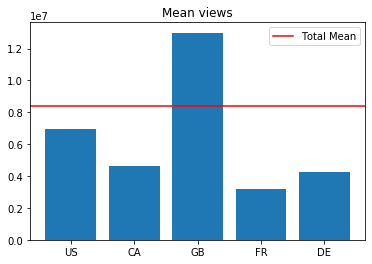

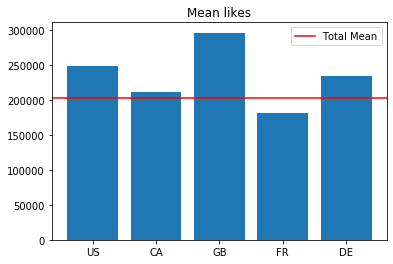

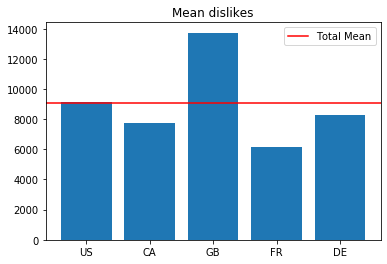

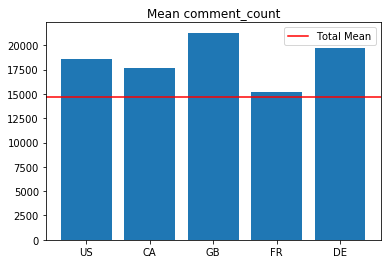

In [5]:
for category in categories: 
    bars = plt.bar(countries, means[category][:5])
    plt.title("Mean "+category)
    line = plt.axhline(y=means[category][5],color='red')
    plt.legend([line], ["Total Mean"])
    plt.show()

Above are bar chart visualizations of the mean number of views, likes, dislikes, and comments. Each chart shows the mean of one of the four previously mentioned attributes for each country with the blue bars. The red line across each chart shows the total mean for that attribute. We can see that the bar for Great Britain is always above the red line for each chart, showing that the country consistently has a higher mean number of views, likes, dislikes, and comments than all of the countries combined, and each individual country. The mean number of views are what differ most between each country, and the mean number of comments and likes appear to be most consistent across countries. 

Below, we create linear regression models for different attributes of the data for all of the countries combined. 

In [6]:
## Linear Regression

## likes and views
likes_views = LinearRegression().fit(df[["likes"]], df["views"])
print("R-squared score using likes to predict views with Linear Regression:", 
      likes_views.score(df[["likes"]], df["views"]))
print("Slope", likes_views.coef_)
print("Intercept", likes_views.intercept_, "\n")

## likes and comment count
likes_comments = LinearRegression().fit(df[["likes"]], df["comment_count"])
print("R-squared score using likes to predict comment count with Linear Regression:", 
      likes_comments.score(df[["likes"]], df["comment_count"]))
print("Slope", likes_comments.coef_)
print("Intercept", likes_comments.intercept_, "\n")

## number of tags and views
df["num_tags"] = ""
for i in range(0, len(df)):
    num_tags = len(df.loc[i]["tags"].strip('][').split(', '))
    df.at[i, "num_tags"] = num_tags
tags_views = LinearRegression().fit(df[["num_tags"]], df["views"])
print("R-squared score using number of tags to predict views with Linear Regression:", 
      tags_views.score(df[["num_tags"]], df["views"]))
print("Slope", tags_views.coef_)
print("Intercept", tags_views.intercept_, "\n")


R-squared score using likes to predict views with Linear Regression: 0.7585511112638205
Slope [48.10941171]
Intercept -1406111.4308787398 

R-squared score using likes to predict comment count with Linear Regression: 0.8411599085217879
Slope [0.07786523]
Intercept -1176.18878380352 

R-squared score using number of tags to predict views with Linear Regression: 0.0016106755686967622
Slope [-108307.88487427]
Intercept 9790261.115783216 



When using a linear regression model, we can look at the R-squared score to determine how much of the data fits the linear relationship. The scores are between 0 and 1. The closer the score is to 1, the better the fit. Looking at the R-squared scores, there is some relationship between the number of likes and number of views. The relationship between likes and comment count is the strongest with an R-squared score of 0.84. We discovered there is almost no relationship between the number of tags and the views of a trending video, as it had an R-squared score of 0.0016. 

Because the relationship between likes and comment count is the strongest, we decided to look at that relationship for each country. We can use these models to determine if likes have more of an effect on the number of comments on a trending video in one country than another. 

R-squared score using likes to predict views with Linear Regression in the US: 0.9263233279485494
Slope [0.08758506]
Intercept -3120.22053807446 



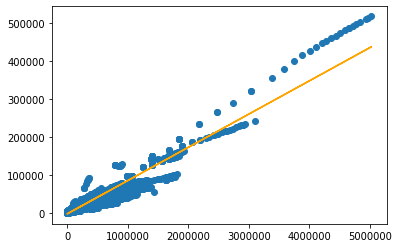

R-squared score using likes to predict views with Linear Regression in the CA: 0.8918680940709445
Slope [0.08474235]
Intercept -342.36599218525953 



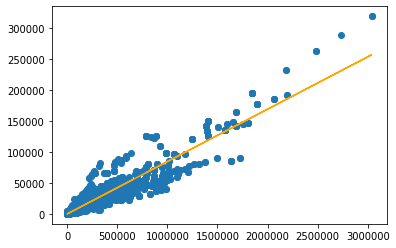

R-squared score using likes to predict views with Linear Regression in the GB: 0.8372815495777424
Slope [0.07896808]
Intercept -2090.5144994035363 



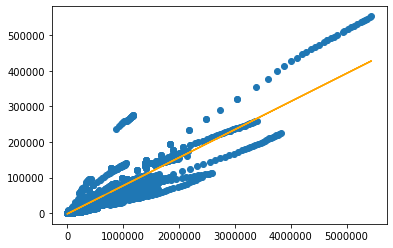

R-squared score using likes to predict views with Linear Regression in the FR: 0.9141361756236307
Slope [0.08695364]
Intercept -537.7102691457185 



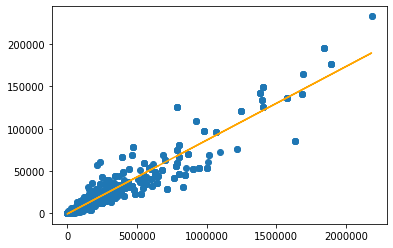

R-squared score using likes to predict views with Linear Regression in the DE: 0.9059480751380748
Slope [0.08649894]
Intercept -578.7482347872829 



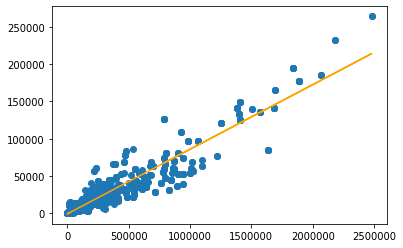

In [7]:
model_US = LinearRegression().fit([[x] for x in stats["US"]["likes"]], stats["US"]["comment_count"])
print("R-squared score using likes to predict views with Linear Regression in the US:", 
      model_US.score([[x] for x in stats["US"]["likes"]], stats["US"]["comment_count"]))
print("Slope", model_US.coef_)
print("Intercept", model_US.intercept_, "\n")
predictions_US = model_US.predict([[x] for x in stats["US"]["likes"]])
plt.scatter(stats["US"]["likes"], stats["US"]["comment_count"])
plt.plot(stats["US"]["likes"], predictions_US, color="orange")
plt.show()

model_CA = LinearRegression().fit([[x] for x in stats["CA"]["likes"]], stats["CA"]["comment_count"])
print("R-squared score using likes to predict views with Linear Regression in the CA:", 
      model_CA.score([[x] for x in stats["CA"]["likes"]], stats["CA"]["comment_count"]))
print("Slope", model_CA.coef_)
print("Intercept", model_CA.intercept_, "\n")
predictions_CA = model_CA.predict([[x] for x in stats["CA"]["likes"]])
plt.scatter(stats["CA"]["likes"], stats["CA"]["comment_count"])
plt.plot(stats["CA"]["likes"], predictions_CA, color="orange")
plt.show()

model_GB = LinearRegression().fit([[x] for x in stats["GB"]["likes"]], stats["GB"]["comment_count"])
print("R-squared score using likes to predict views with Linear Regression in the GB:", 
      model_GB.score([[x] for x in stats["GB"]["likes"]], stats["GB"]["comment_count"]))
print("Slope", model_GB.coef_)
print("Intercept", model_GB.intercept_, "\n")
predictions_GB = model_GB.predict([[x] for x in stats["GB"]["likes"]])
plt.scatter(stats["GB"]["likes"], stats["GB"]["comment_count"])
plt.plot(stats["GB"]["likes"], predictions_GB, color="orange")
plt.show()

model_FR = LinearRegression().fit([[x] for x in stats["FR"]["likes"]], stats["FR"]["comment_count"])
print("R-squared score using likes to predict views with Linear Regression in the FR:", 
      model_FR.score([[x] for x in stats["FR"]["likes"]], stats["FR"]["comment_count"]))
print("Slope", model_FR.coef_)
print("Intercept", model_FR.intercept_, "\n")
predictions_FR = model_FR.predict([[x] for x in stats["FR"]["likes"]])
plt.scatter(stats["FR"]["likes"], stats["FR"]["comment_count"])
plt.plot(stats["FR"]["likes"], predictions_FR, color="orange")
plt.show()

model_DE = LinearRegression().fit([[x] for x in stats["DE"]["likes"]], stats["DE"]["comment_count"])
print("R-squared score using likes to predict views with Linear Regression in the DE:", 
      model_DE.score([[x] for x in stats["DE"]["likes"]], stats["DE"]["comment_count"]))
print("Slope", model_DE.coef_)
print("Intercept", model_DE.intercept_, "\n")
predictions_DE = model_DE.predict([[x] for x in stats["DE"]["likes"]])
plt.scatter(stats["DE"]["likes"], stats["DE"]["comment_count"])
plt.plot(stats["DE"]["likes"], predictions_DE, color="orange")
plt.show()


Almost all of the R-squared scores for each country, besides Great Britain, are about 0.9, which is an even stronger relationship than overall. The R-squared score for Great Britain is about 0.84, which is about the same as the overall R-squared score. The linear relationship between the number of likes and the number of comments is pretty strong for the United States, Canada, France, and Germany. In general, for those countries, the number comments increases with the number of likes. The same goes for Great Britain, although it is not as strong of a relationship. 